In [1]:
#Importing required libraries

import os
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import gensim

In [2]:
#Setting the working directory

os.chdir("C:/Users/Guest/Desktop/harsh jain/NLP DataSet - Sarcasm Detection")
print(os.getcwd())

C:\Users\Guest\Desktop\harsh jain\NLP DataSet - Sarcasm Detection


In [3]:
# loading the data in python environment.
df = pd.read_json("Sarcasm_Headlines_Dataset (1).json",lines =True)
df = df[['headline', 'is_sarcastic']]
df.head(10)

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
5,my white inheritance,0
6,5 ways to file your taxes with less stress,0
7,richard branson's global-warming donation near...,1
8,shadow government getting too large to meet in...,1
9,lots of parents know this scenario,0


In [4]:
# check for columns with null values
df.is_sarcastic.isnull().any()
df.headline.isnull().any()

False

# Exploratory Data Analysis

In [5]:
#Convert all words into lowercase

df['headline'] = df.headline.apply(lambda x:x.lower())

In [6]:
# remove all punctuations in headline

df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

In [7]:
#Check for imbalanced classes in dataset
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df.head()

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,thirtysomething scientists unveil doomsday clo...,1,8,8,False
1,dem rep totally nails why congress is falling ...,0,13,13,False
2,eat your veggies 9 deliciously different recipes,0,7,7,True
3,inclement weather prevents liar from getting t...,1,8,8,False
4,mother comes pretty close to using word stream...,1,9,9,False


### Some Visualization

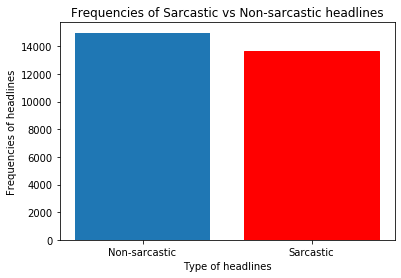

In [8]:
# To check frequencies of Sarcastic vs Non-sarcastic headline

sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.show()

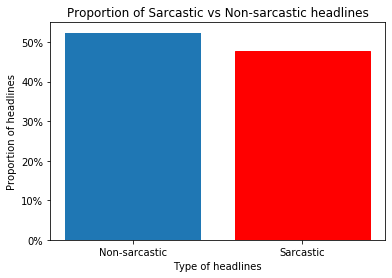

In [9]:
# To check proportion of Sarcastic vs Non-sarcastic headlines

plt.xlabel('Type of headlines')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


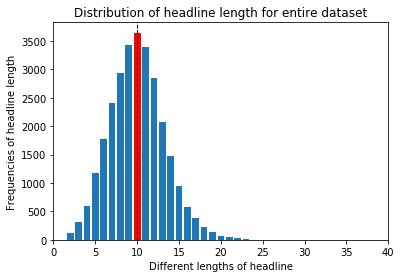

In [10]:
# To check distribution of headlines length

all_dat = df.groupby('headline_count').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_count').count()

# check distribution of headlines for entire dataset
plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.title('Distribution of headline length for entire dataset')
plt.xlim([0,40])
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

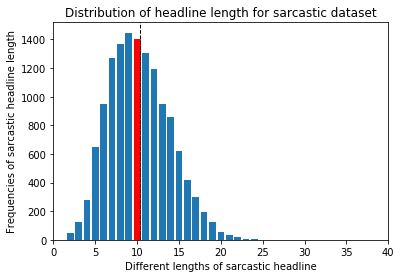

In [11]:
# check distribution of headline length for sarcastic dataset

plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.title('Distribution of headline length for sarcastic dataset')
plt.xlim([0,40])
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

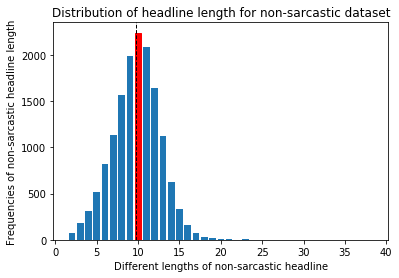

In [12]:
# check distribution of headline length for non-sarcastic dataset 

plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

### Data Processiong

In [13]:
# Tokenization: Split the text into sentences and the sentences into words
# remove stopwords
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)  
    return lda_tokens

In [14]:
# Lemmatization
def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma

In [15]:
# Now we can define a function to prepare the text for topic modelling
def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [16]:
# Now we can see how our text data are converted
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)

In [17]:
# First, we are creating a dictionary from the data, then convert to bag-of-words corpus 
# save the dictionary and corpus for future use.
from gensim import corpora
import pickle

# Convert all headlines into a corpus of words, with each word as a token
dictionary = corpora.Dictionary(text_data) 

# Convert each headline into the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in text_data] 
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  

In [18]:
# We are asking LDA to find 6 topics in the data
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 6, id2word=dictionary, passes=15)
ldamodel.save('model6.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.015*"world" + 0.009*"woman" + 0.007*"friend" + 0.006*"going" + 0.006*"around" + 0.006*"really" + 0.005*"country" + 0.005*"introduce" + 0.005*"first" + 0.005*"want"')
(1, '0.018*"woman" + 0.009*"school" + 0.008*"change" + 0.008*"video" + 0.006*"student" + 0.006*"health" + 0.006*"black" + 0.005*"teacher" + 0.005*"climate" + 0.005*"never"')
(2, '0.013*"report" + 0.012*"study" + 0.009*"find" + 0.008*"american" + 0.008*"first" + 0.006*"couple" + 0.006*"years" + 0.005*"sander" + 0.005*"would" + 0.005*"getting"')
(3, '0.008*"employee" + 0.008*"family" + 0.007*"nation" + 0.007*"right" + 0.007*"woman" + 0.005*"government" + 0.005*"refugee" + 0.004*"start" + 0.004*"story" + 0.004*"pretty"')
(4, '0.008*"court" + 0.007*"movie" + 0.007*"plan" + 0.006*"announce" + 0.006*"season" + 0.005*"supreme" + 0.005*"record" + 0.005*"unveil" + 0.005*"marriage" + 0.005*"every"')
(5, '0.063*"trump" + 0.017*"donald" + 0.014*"house" + 0.013*"white" + 0.011*"clinton" + 0.010*"obama" + 0.008*"president" + 0.00

# Word Cloud

In [19]:
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Loading data 
df1 = pd.read_json("Sarcasm_Headlines_Dataset (1).json",lines =True)
df1 = df[['headline', 'is_sarcastic']]

In [21]:
# Converting the headline to Lower Case
df1['headline']= df1['headline'].str.lower()
df1['headline'].head()

0    thirtysomething scientists unveil doomsday clo...
1    dem rep totally nails why congress is falling ...
2     eat your veggies 9 deliciously different recipes
3    inclement weather prevents liar from getting t...
4    mother comes pretty close to using word stream...
Name: headline, dtype: object

In [22]:
# split the data 
all_headline = df1['headline'].str.split(' ')
all_headline.head()

0    [thirtysomething, scientists, unveil, doomsday...
1    [dem, rep, totally, nails, why, congress, is, ...
2    [eat, your, veggies, 9, deliciously, different...
3    [inclement, weather, prevents, liar, from, get...
4    [mother, comes, pretty, close, to, using, word...
Name: headline, dtype: object

In [23]:
# data cleaning
all_headline_cleaned = []

for text in all_headline:
    text = [x.strip(string.punctuation) for x in text]
    all_headline_cleaned.append(text)

all_headline_cleaned[0]

text_headline = [" ".join(text) for text in all_headline_cleaned]
final_text_headline = " ".join(text_headline)
final_text_headline[:100]

'thirtysomething scientists unveil doomsday clock of hair loss dem rep totally nails why congress is '

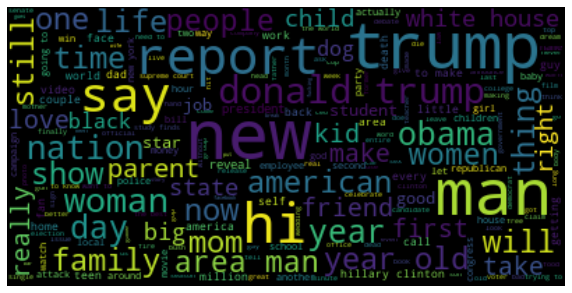

In [24]:
# worldcloud with 200 frequent words
stopwords = set(STOPWORDS)

wordcloud_headline = WordCloud(stopwords = stopwords, background_color="black", 
                           max_font_size=50, max_words=200).generate(final_text_headline)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud_headline, interpolation='bilinear')
plt.axis("off")
plt.show()

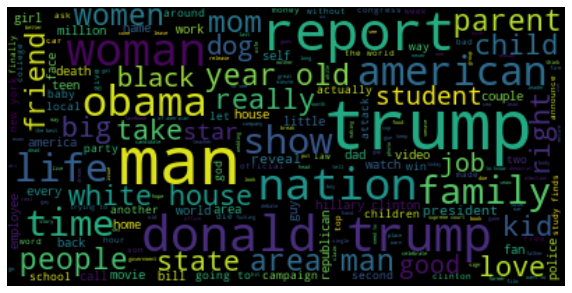

In [25]:
# updated wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["hi","will","still","thing","first","say","new","now","one","day","make","getting","find","year"])
wordcloud_headline = WordCloud(stopwords = stopwords, background_color="black", 
                           max_font_size=50, max_words=200).generate(final_text_headline)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud_headline, interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 50 sarcastic words

In [26]:
# filter sarcastic headline from whole data set
sar_headline = df1[df1.is_sarcastic == 1]

In [27]:
sar_headline.shape

(13634, 2)

In [28]:
sar_headline['headline']= sar_headline['headline'].str.lower()
sar_headline =sar_headline['headline'].str.split(' ')

In [29]:
# build the text corpus which will be used to build the word cloud.
all_sar_cleaned = []

for text in sar_headline:
    text = [x.strip(string.punctuation) for x in text]
    all_sar_cleaned.append(text)

all_sar_cleaned[0]

text_sar = [" ".join(text) for text in all_sar_cleaned]
final_text_sar = " ".join(text_sar)
final_text_sar[:100]

'thirtysomething scientists unveil doomsday clock of hair loss inclement weather prevents liar from g'

In [30]:
# remove stopwords
stopwords = set(STOPWORDS)
stopwords.update(["hi","will","still","thing","first","say","new","now","one","day","make","getting","take","back","year"])

In [31]:
# top 50 sarcastic words
stopwords_removed = [word for word in final_text_sar.split() if word not in stopwords]

lemmatizer = WordNetLemmatizer()
filtered_words_sar = [lemmatizer.lemmatize(t) for t in stopwords_removed]
counted_words_sar = collections.Counter(filtered_words_sar)

word_count_sar = {}

for letter, count in counted_words_sar.most_common(50):
    word_count_sar[letter] = count
    
for i,j in word_count_sar.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: man, count: 1156
Word: report, count: 576
Word: area, count: 490
Word: woman, count: 441
Word: trump, count: 343
Word: time, count: 327
Word: american, count: 316
Word: find, count: 281
Word: study, count: 243
Word: nation, count: 234
Word: u.s, count: 219
Word: life, count: 216
Word: house, count: 212
Word: family, count: 209
Word: child, count: 200
Word: friend, count: 191
Word: white, count: 185
Word: people, count: 177
Word: going, count: 175
Word: obama, count: 174
Word: last, count: 168
Word: way, count: 161
Word: local, count: 160
Word: go, count: 157
Word: guy, count: 155
Word: nation's, count: 155
Word: good, count: 150
Word: work, count: 148
Word: plan, count: 147
Word: every, count: 147
Word: parent, count: 145
Word: little, count: 144
Word: school, count: 141
Word: home, count: 137
Word: know, count: 136
Word: say, count: 136
Word: announces, count: 134
Word: show, count: 134
Word: right, count: 133
Word: mom, count: 132
Word: clinton, count: 132
Word: job, count: 130

# Sarcasm Detection

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

In [33]:
df1.head(),df1.shape

(                                            headline  is_sarcastic
 0  thirtysomething scientists unveil doomsday clo...             1
 1  dem rep totally nails why congress is falling ...             0
 2   eat your veggies 9 deliciously different recipes             0
 3  inclement weather prevents liar from getting t...             1
 4  mother comes pretty close to using word stream...             1,
 (28619, 2))

In [34]:
# stemming and stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
words = stopwords.words("english")

df1['headline'] = df1['headline'].apply(lambda x: " ".join([stemmer.stem(i) 
                                                               for i in re.sub("[^a-zA-Z]", " ", x).split()
                                                               if i not in words]))

In [35]:
df1.head()

,headline,is_sarcastic
0,thirtysometh scientist unveil doomsday clock h...,1
1,dem rep total nail congress fall short gender ...,0
2,eat veggi delici differ recip,0
3,inclement weather prevent liar get work,1
4,mother come pretti close use word stream corre...,1


In [36]:
# Split the dataset and Creating the Training and Test Datasets
target = df1['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(df['headline'], target, test_size=0.20, random_state=100)

print(df.shape); print(X_train.shape); print(X_test.shape); print(y_train.shape); print(y_test.shape)

(28619, 5)
(22895,)
(5724,)
(22895,)
(5724,)


In [37]:
# Converting Text to Word Frequency Vectors with TfidfVectorizer.
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))

test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))


In [38]:
train_tfIdf.shape,test_tfIdf.shape

((22895, 23536), (5724, 23536))

## Model Building and Evaluation

In [39]:
# Build the logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logisticRegr = LogisticRegression()
logisticRegr.fit(train_tfIdf, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
# Prediction and evaluation of model
predictions = logisticRegr.predict(test_tfIdf)

accuracy_LR = metrics.accuracy_score(y_test, predictions)
print(accuracy_LR)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

#Accuracy = (2487+2062)*100/(2487+542+634+2061)
#Accuracy = 79.45 %

0.7945492662473794
[[2487  542]
 [ 634 2061]]


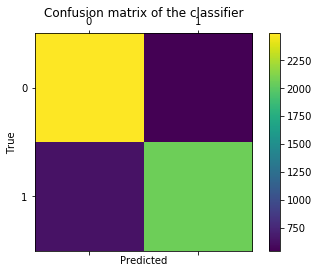

In [41]:
# graph of cofusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
# build naive bayes model
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(train_tfIdf, y_train)

# Prediction and evaluation of model
pred2 = nb_classifier.predict(test_tfIdf) 

# Calculate the accuracy score: score
accuracy_tfidf = metrics.accuracy_score(y_test, pred2)
print(accuracy_tfidf)

Conf_metrics_tfidf = metrics.confusion_matrix(y_test, pred2)
print(Conf_metrics_tfidf)

#Accuracy = (2560+2042)*100/(2560+469+653+2042)
#Accuracy = 80.39% 

0.8039832285115304
[[2560  469]
 [ 653 2042]]


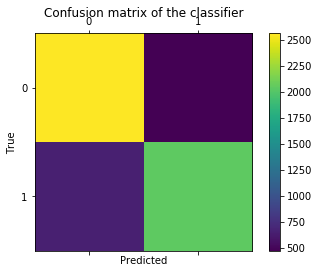

In [43]:
# graph of cofusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(Conf_metrics_tfidf)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [44]:
# Bulid random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 500)

classifier.fit(train_tfIdf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=500,
                       verbose=0, warm_start=False)

In [45]:
# Prediction and evaluation of model
predRF = classifier.predict(test_tfIdf) 

# Calculate the accuracy score
accuracy_RF = metrics.accuracy_score(y_test, predRF)
print(accuracy_RF)

Conf_metrics_RF = metrics.confusion_matrix(y_test, predRF)
print(Conf_metrics_RF)

#Accuracy = (2533+1728)*100/(2533+496+967+1728)
#Accuracy = 74.49 %

0.7449336128581412
[[2545  484]
 [ 976 1719]]


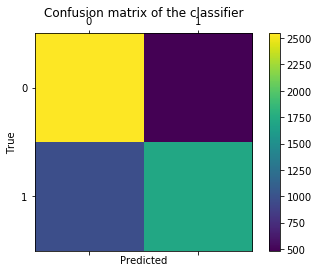

In [46]:
# graph of cofusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(Conf_metrics_RF)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## After evaluation of model we conclude that naive bayes is best model on our data set

In [47]:
                                       ##### End of project #####